In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import xgboost as xgb
import joblib
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [20]:
data = pd.read_csv("housing.csv")
data.dropna(inplace=True)

In [21]:
X = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [22]:
X_train = pd.get_dummies(X_train, columns=["ocean_proximity"])
X_test = pd.get_dummies(X_test, columns=["ocean_proximity"])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Save feature columns and scaler
joblib.dump(list(X_train.columns), "feature_columns.joblib")
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [23]:
joblib.dump(list(X_train.columns), "feature_columns.joblib")
joblib.dump(scaler, "scaler.joblib")



['scaler.joblib']

RMSE: 50745.57333839689
R2 Score: 0.811694393388223


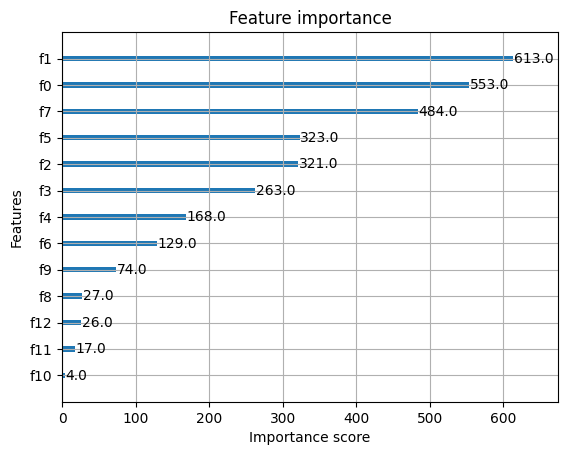

In [24]:
mlflow.set_experiment("house_price_prediction")

with mlflow.start_run():
    # Define and train model
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train_s, y_train)

    # Make predictions
    y_pred = model.predict(X_test_s)

    # Calculate metrics
    rmse = root_mean_squared_error(y_test, y_pred)  # Use root_mean_squared_error instead
    r2 = r2_score(y_test, y_pred)

    # Log parameters and metrics
    mlflow.log_params(model.get_params())
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)

    # Log feature importance plot
    xgb.plot_importance(model)
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")

    # Infer signature and log model
    X_test_df = pd.DataFrame(X_test_s, columns=X_train.columns)
    input_example = X_test_df.iloc[[0]]
    signature = infer_signature(X_test_df, y_pred)
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="xgb_model",
        input_example=input_example,
        signature=signature
    )

    # Save the model for FastAPI
    joblib.dump(model, "model.joblib")

    print(f"RMSE: {rmse}")
    print(f"R2 Score: {r2}")